<a href="https://colab.research.google.com/github/Moonyflay/BigHW-LazyFCA-SK/blob/main/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

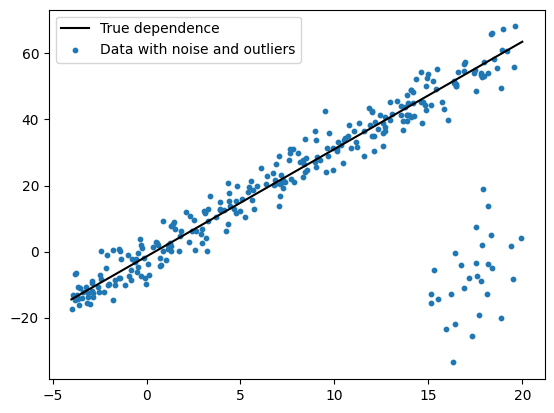

In [ ]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

In [ ]:
#<YOUR CODE>
from sklearn.linear_model import LinearRegression
from tqdm import trange

100%|██████████| 1000/1000 [00:00<00:00, 21315.88it/s]


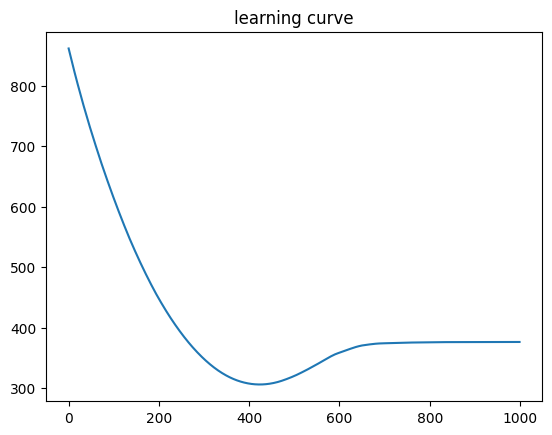

In [ ]:
X_expanded = np.concatenate([X, np.ones(shape=(len(X), 1))], axis=1)

# Initialize the model parameters with zeros
w = np.zeros(dtype=float, shape=X_expanded.shape[1])

loss_values = [] # a list to keep track of how the loss value changes
learning_rate = 0.001

# Training loop
for _ in trange(1000):
  # Your turn: calculate the gradient of MSE with respect to w:
  n = len(X_expanded)
  gradient = np.dot(X_expanded.T, np.sign(np.dot(X_expanded, w) - y)) / n

  # Automatic checks
  assert gradient.shape == w.shape

  # Gradient descent step
  w -= learning_rate * gradient

  # Calculate and record the new loss value
  loss_values.append(
      ((X_expanded @ w - y)**2).mean()
  )

# Plotting the evolution of loss values
plt.plot(loss_values)
plt.title('learning curve')
plt.show();

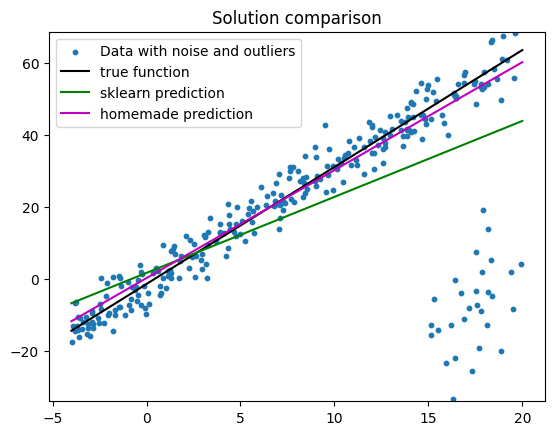

In [ ]:

linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(x.reshape(-1, 1))
x_expanded = np.concatenate([x[:,None],
    np.ones(shape=(len(x), 1))
], axis=1)

plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(x, true_function(x), label='true function', c='k')
plt.plot(x, y_pred, label='sklearn prediction', c='g')
plt.plot(x, x_expanded @ w, label='homemade prediction', c='m')
plt.title('Solution comparison')
plt.ylim(y.min() - 0.5, y.max() + 0.5)
plt.legend();

### Comment
Plots of homemade and **sklearn** solutions differ, because **LinearRegression** uses MSE as it's loss function. The MAE loss functoin is more robust to outliers then MSE, therefore homemade solution is less affected by the bottom right cluster.

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

In [ ]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):

    def __init__(self, learning_rate=.001, n_iter=1000, loss='MAE'):
        if loss == 'MSE':
          self.loss_func = self.MSE_loss
        elif loss == 'MAE':
          self.loss_func = self.MAE_loss
        else:
          raise ValueError('Parameter \"loss\" must be equal to \"MAE\" or \"MSE\"')

        self.learning_rate = learning_rate
        self.loss_values = []
        self.n_iter = n_iter
        return

    def fit(self, x, y):
        X_expanded = np.concatenate([X, np.ones(shape=(len(X), 1))], axis=1)
        w = np.zeros(dtype=float, shape=X_expanded.shape[1])
        for _ in trange(self.n_iter):

            gradient = self.loss_func(X_expanded, w, y)
            # Gradient descent step
            w -= self.learning_rate * gradient

            # Calculate and record the new loss value
            self.loss_values.append(
                ((X_expanded @ w - y)**2).mean()
            )
        self.w = w
        return

    def predict(self, x):
      x_expanded = np.concatenate([x[:,None],
        np.ones(shape=(len(x), 1))
        ], axis=1)
      return x_expanded @ self.w

    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

    def plot_learning_curve(self):
        plt.plot(loss_values)
        plt.title('learning curve')
        plt.show()
        return

    def MAE_loss(self, X_expanded, w, y):
        n = len(X_expanded)
        gradient = np.dot(X_expanded.T, np.sign(np.dot(X_expanded, w) - y)) / n
        return gradient

    def MSE_loss(self, X_expanded, w, y):
        n = len(X_expanded)
        gradient = 2*np.dot(X_expanded.T, (np.dot(X_expanded, w) - y)) / n
        return gradient


100%|██████████| 1000/1000 [00:00<00:00, 6394.13it/s]


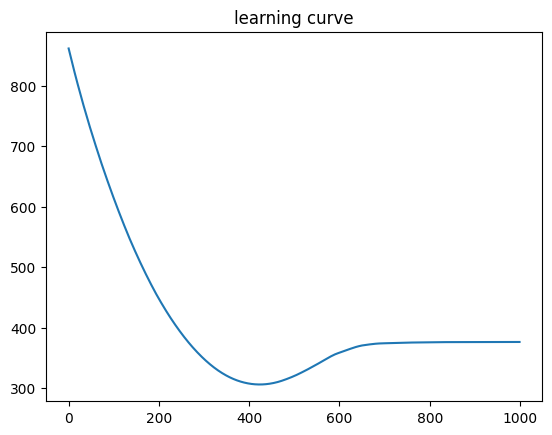

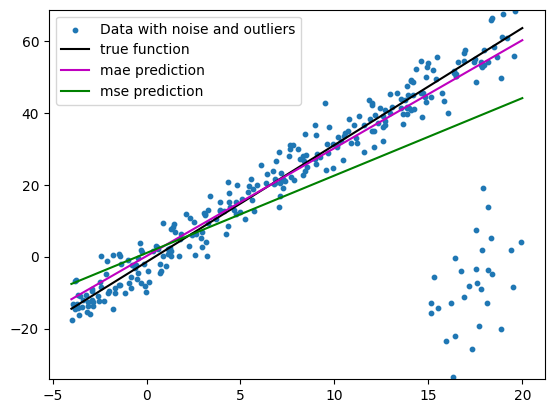

In [ ]:
homemade_mae = LinearRergessionSGD(loss='MAE',  learning_rate=.001)
homemade_mse = LinearRergessionSGD(loss='MSE',  learning_rate=.001)
homemade_mae.fit(X, y)
homemade_mse.fit(X, y)
pred_mae = homemade_mae.predict(x)
pred_mse = homemade_mse.predict(x)

homemade_mae.plot_learning_curve()
#homemade_mse.plot_learning_curve()

plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(x, true_function(x), label='true function', c='k')
plt.plot(x, pred_mae, label='mae prediction', c='m')
plt.plot(x, pred_mse, label='mse prediction', c='g')
plt.ylim(y.min() - 0.5, y.max() + 0.5)
plt.legend();

### Comment

The results are the same.